# COVID-19 

This is my new version of analyses of COVID-19.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
import datetime
import time
from pathlib import Path

# Canada

In [2]:
from src.phac import PHAC

can = PHAC()
as_of = "2020-05-23"

## Total Cases

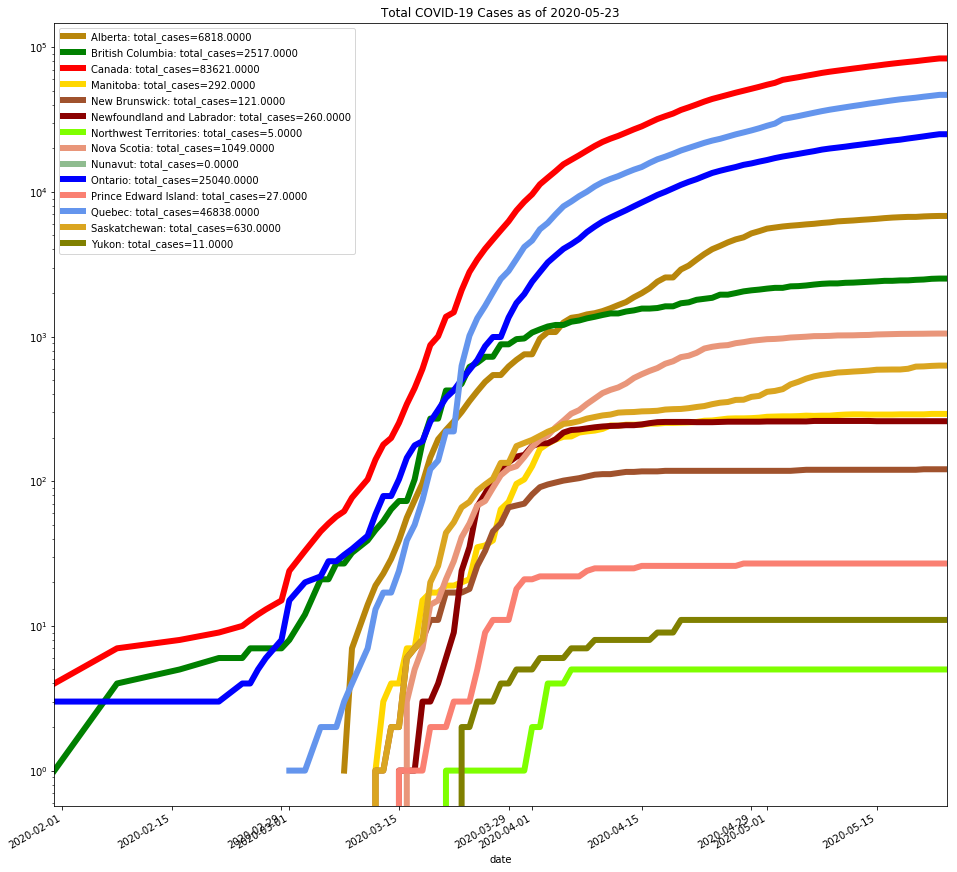

In [3]:
can_tc_fig = can.plot_var("total_cases", *can.provinces,
    figsize=(16,16),
    log_scale=True,
    colours=can.prov_colours,
    #date_start="2020-03-01",
    lw=6,
    title=f"Total COVID-19 Cases as of {as_of}"  
)


plt.show()

In [4]:
var_pivot = can.var_by_location("total_cases", *can.provinces)
var_pivot[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-05-18,78072.0,260.0,27.0,1043.0,120.0,43627.0,22957.0,290.0,592.0,6683.0,2444.0,11.0,5.0,0.0
2020-05-19,79112.0,260.0,27.0,1044.0,120.0,44197.0,23384.0,290.0,599.0,6716.0,2446.0,11.0,5.0,0.0
2020-05-20,80102.0,260.0,27.0,1045.0,120.0,44775.0,23774.0,290.0,620.0,6716.0,2467.0,11.0,5.0,0.0
2020-05-21,81324.0,260.0,27.0,1046.0,121.0,45495.0,24187.0,290.0,622.0,6768.0,2479.0,11.0,5.0,0.0
2020-05-22,82480.0,260.0,27.0,1048.0,121.0,46141.0,24628.0,292.0,627.0,6800.0,2507.0,11.0,5.0,0.0
2020-05-23,83621.0,260.0,27.0,1049.0,121.0,46838.0,25040.0,292.0,630.0,6818.0,2517.0,11.0,5.0,0.0
2020-05-24,83621.0,260.0,27.0,1049.0,121.0,46838.0,25040.0,292.0,630.0,6818.0,2517.0,11.0,5.0,0.0


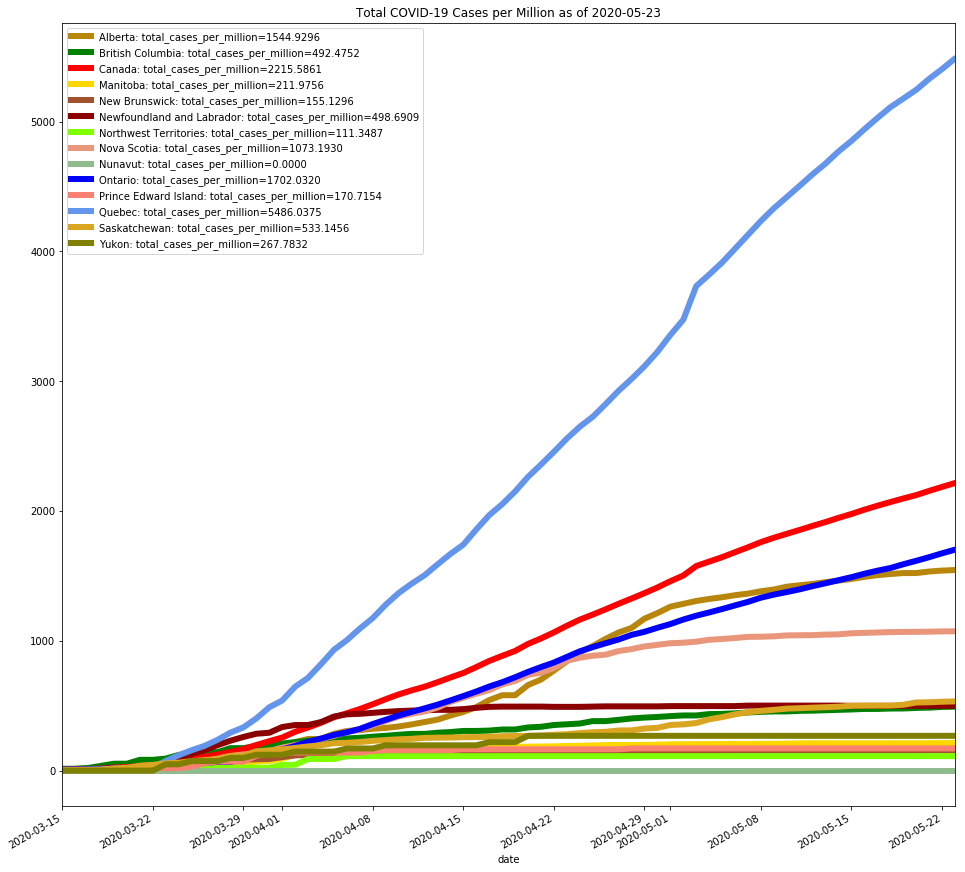

In [5]:
can_tcpm_fig = can.plot_var("total_cases_per_million", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-15",
    date_end=as_of,
    lw=6,
    title=f"Total COVID-19 Cases per Million as of {as_of}"  
)


plt.show()

## New cases

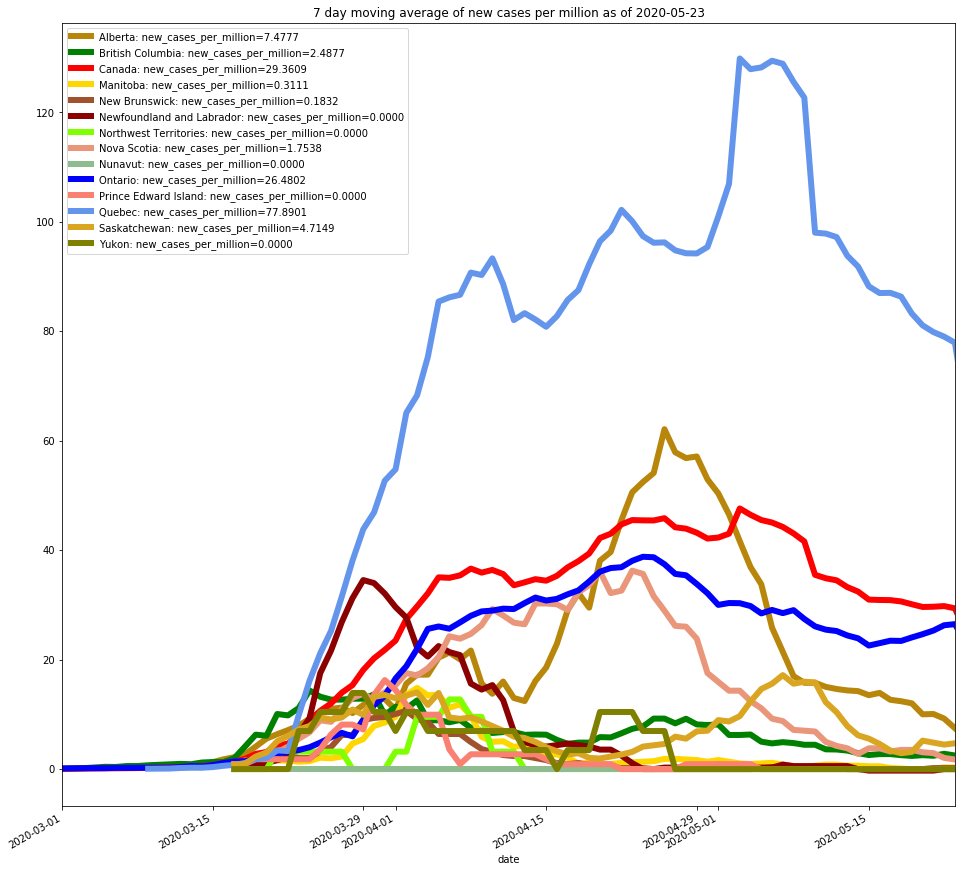

In [6]:
ma_win = 7
can_nc_fig = can.plot_var("new_cases_per_million", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)


plt.show()

In [7]:
can_nc = can.var_by_location("new_cases", *can.provinces)
can_nc["2020-05-02":"2020-05-09"][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-05-02,1653.0,0.0,0.0,4.0,0.0,1008.0,511.0,1.0,6.0,97.0,26.0,0.0,0.0,0.0
2020-05-03,2760.0,0.0,0.0,8.0,0.0,2209.0,434.0,1.0,12.0,96.0,0.0,0.0,0.0,0.0
2020-05-04,1298.0,0.0,0.0,14.0,0.0,758.0,370.0,0.0,34.0,70.0,53.0,0.0,0.0,0.0
2020-05-05,1274.0,0.0,0.0,6.0,1.0,794.0,387.0,1.0,20.0,57.0,8.0,0.0,0.0,0.0
2020-05-06,1450.0,0.0,0.0,7.0,1.0,910.0,412.0,2.0,25.0,70.0,23.0,0.0,0.0,0.0
2020-05-07,1426.0,2.0,0.0,9.0,0.0,911.0,399.0,-1.0,19.0,54.0,33.0,0.0,0.0,0.0
2020-05-08,1512.0,0.0,0.0,1.0,0.0,912.0,477.0,1.0,13.0,81.0,27.0,0.0,0.0,0.0
2020-05-09,1268.0,0.0,0.0,3.0,0.0,836.0,346.0,0.0,9.0,59.0,15.0,0.0,0.0,0.0


## Tests

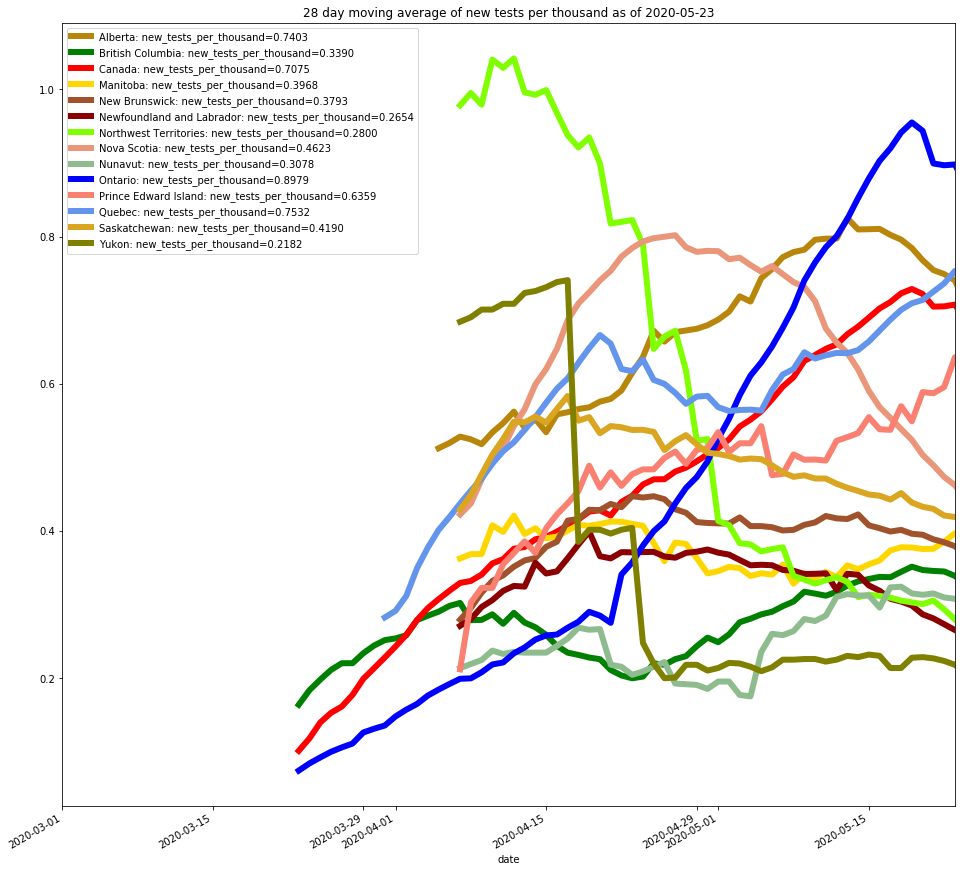

In [8]:
ma_win = 28

can_nt_fig = can.plot_var("new_tests_per_thousand", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new tests per thousand as of {as_of}"  
)


plt.show()

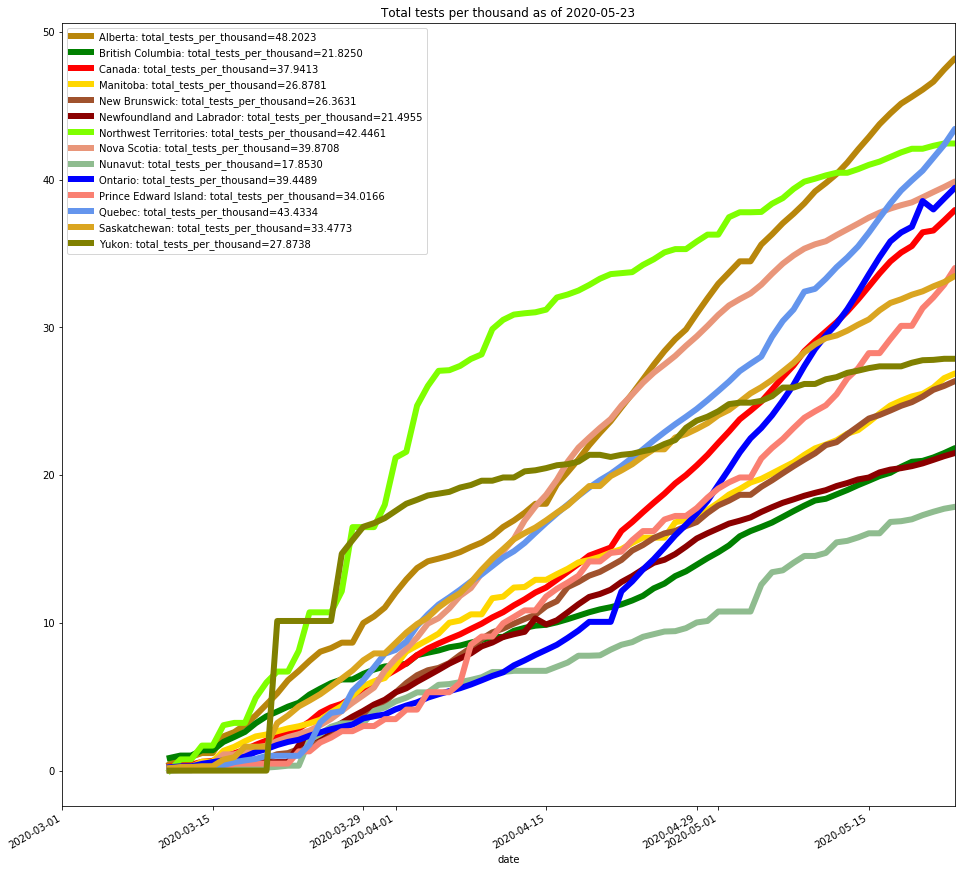

In [9]:
can_tt_fig = can.plot_var("total_tests_per_thousand", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"Total tests per thousand as of {as_of}"  
)


plt.show()

In [10]:
can.df[-13:]

,date,location,total_cases,total_deaths,total_tests,population,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_cases,new_cases_per_million,new_deaths,new_deaths_per_million,new_tests,new_tests_per_thousand
1168,2020-05-24,Alberta,6818,135.0,212724.0,4413146.0,1544.929626,30.590422,48.202348,0.0,0.0,0.0,0.0,0.0,0.0
1169,2020-05-24,Saskatchewan,630,7.0,39559.0,1181666.0,533.145576,5.923840,33.477311,0.0,0.0,0.0,0.0,0.0,0.0
1170,2020-05-24,Manitoba,292,7.0,37025.0,1377517.0,211.975605,5.081607,26.878071,0.0,0.0,0.0,0.0,0.0,0.0
1171,2020-05-24,Ontario,25040,2048.0,580366.0,14711827.0,1702.031977,139.207727,39.448941,0.0,0.0,0.0,0.0,0.0,0.0
1172,2020-05-24,Quebec,46838,3940.0,370820.0,8537674.0,5486.037532,461.484006,43.433375,0.0,0.0,0.0,0.0,0.0,0.0
1173,2020-05-24,Newfoundland and Labrador,260,3.0,11207.0,521365.0,498.690936,5.754126,21.495497,0.0,0.0,0.0,0.0,0.0,0.0
1174,2020-05-24,New Brunswick,121,0.0,20563.0,779993.0,155.129597,0.000000,26.363057,0.0,0.0,0.0,0.0,0.0,0.0
1175,2020-05-24,Nova Scotia,1049,58.0,38972.0,977457.0,1073.192990,59.337649,39.870808,0.0,0.0,0.0,0.0,0.0,0.0
1176,2020-05-24,Prince Edward Island,27,0.0,5380.0,158158.0,170.715361,0.000000,34.016616,0.0,0.0,0.0,0.0,0.0,0.0
1177,2020-05-24,Yukon,11,0.0,1145.0,41078.0,267.783242,0.000000,27.873801,0.0,0.0,0.0,0.0,0.0,0.0


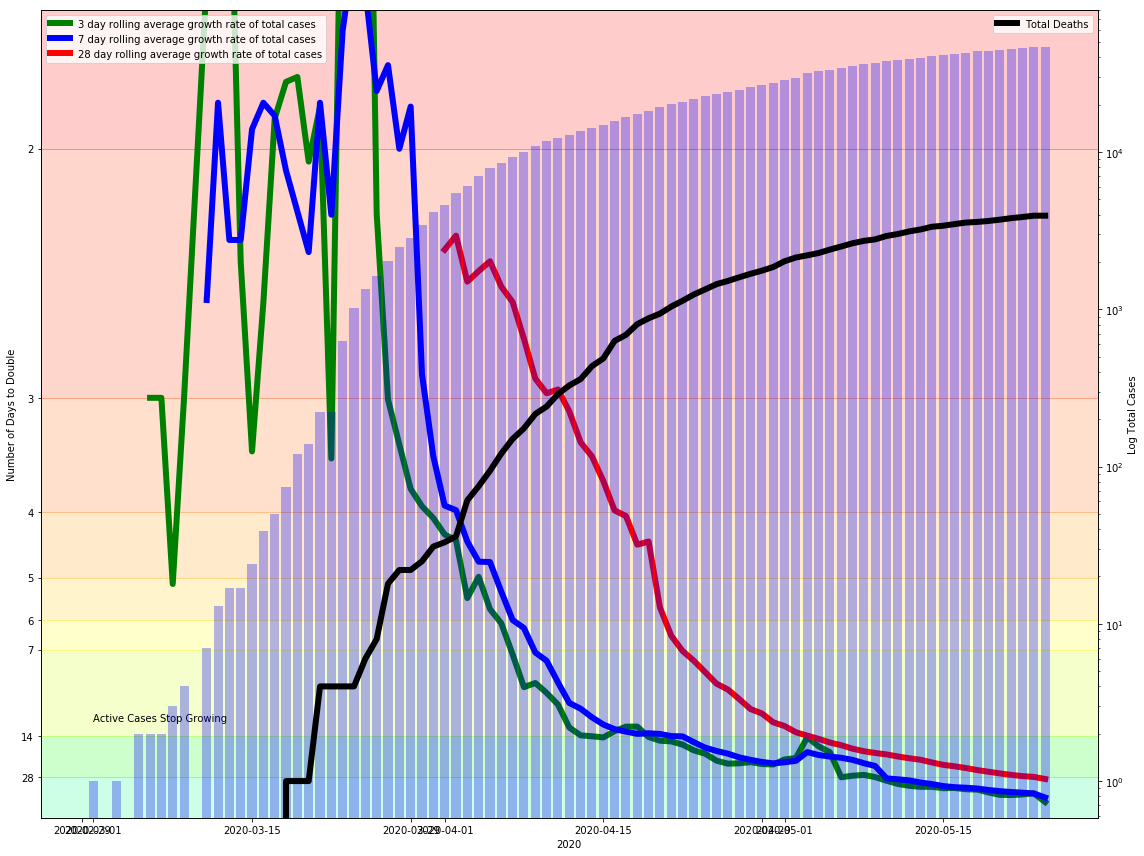

In [11]:
fig = can.plot_location('Quebec', from_date="2020-03-01")

plt.show()

# World

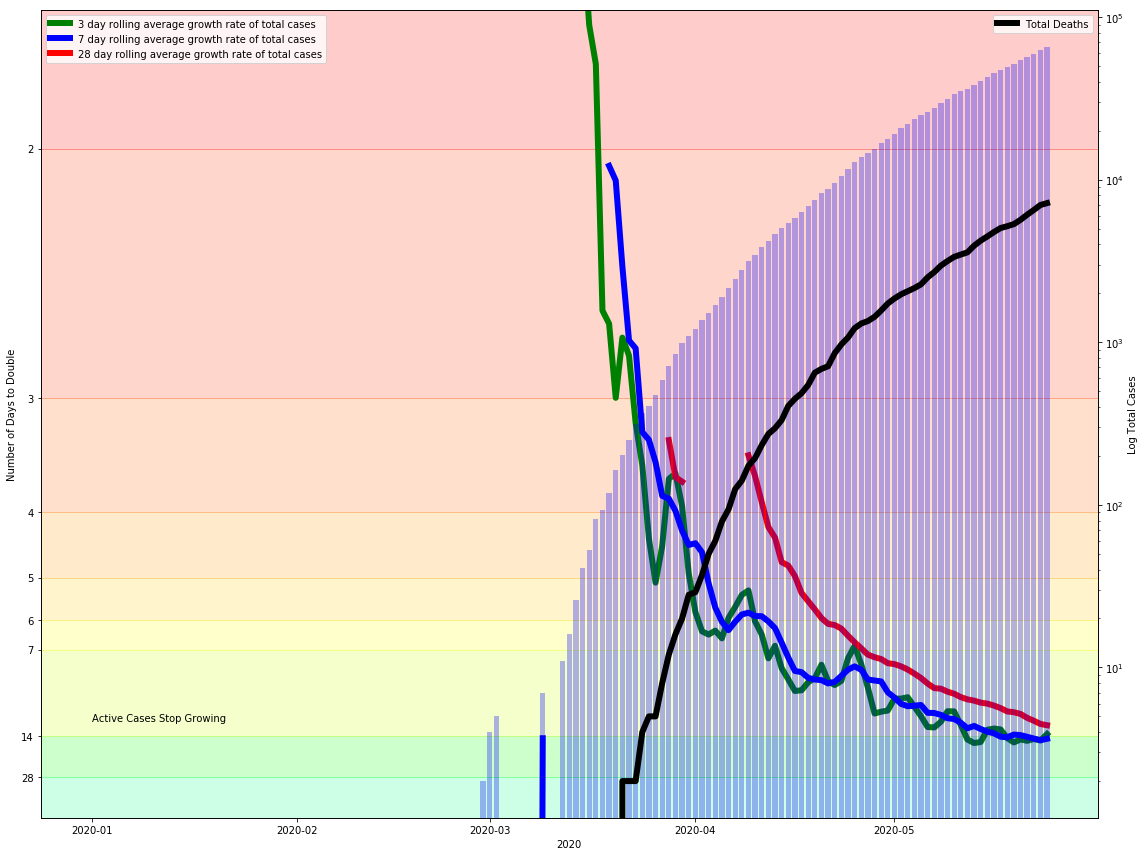

In [12]:
from src.ecdc import ECDC

world = ECDC()
fig = world.plot_location('Mexico', from_date="2020-01-01")

plt.show()

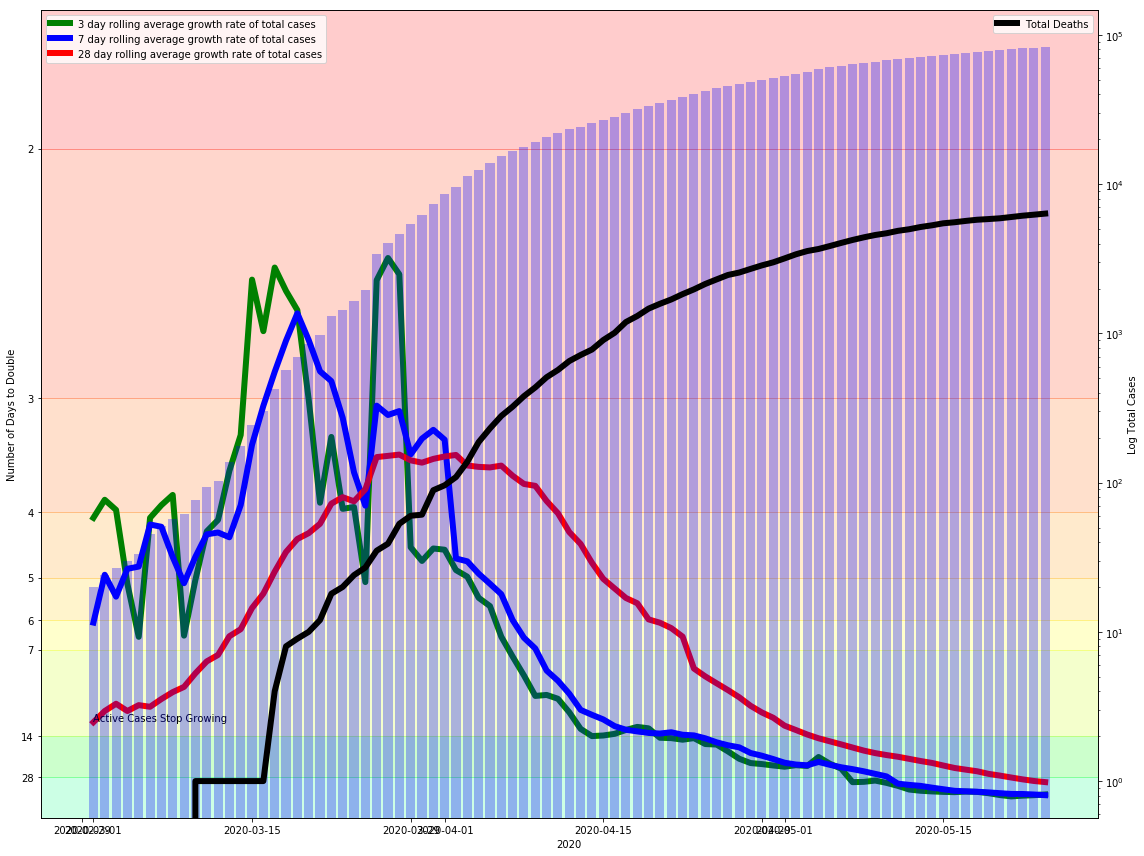

In [13]:
fig = world.plot_location('Canada', from_date="2020-03-01")

plt.show()

In [14]:
countries = ['Canada', 
             #'China', 
             'United States', 
             'Italy', 
             'Spain', 
             'United Kingdom', 
             'Germany',
             'Russia']

world.cum_pos_test_rate(*countries)[-7:]

location,Canada,Germany,Italy,Russia,Spain,United Kingdom,United States
date,,,,,,,
2020-05-18,0.058327,0.055499,0.074123,0.039422,0.120665,0.129141,0.125932
2020-05-19,0.058387,0.055662,0.072760,0.039536,0.120890,0.126892,0.123627
2020-05-20,0.057615,0.055915,0.071475,0.039580,0.121160,0.124618,0.121236
2020-05-21,0.058246,0.056151,0.070101,0.039371,0.121411,0.119911,0.119146
2020-05-22,0.058016,0.056298,0.068702,0.039076,0.122342,0.116994,0.117541
2020-05-23,0.057594,0.056500,0.067427,0.038850,0.122584,0.118526,0.116174
2020-05-24,0.058391,0.056637,0.067624,0.038672,NaN,NaN,0.117715


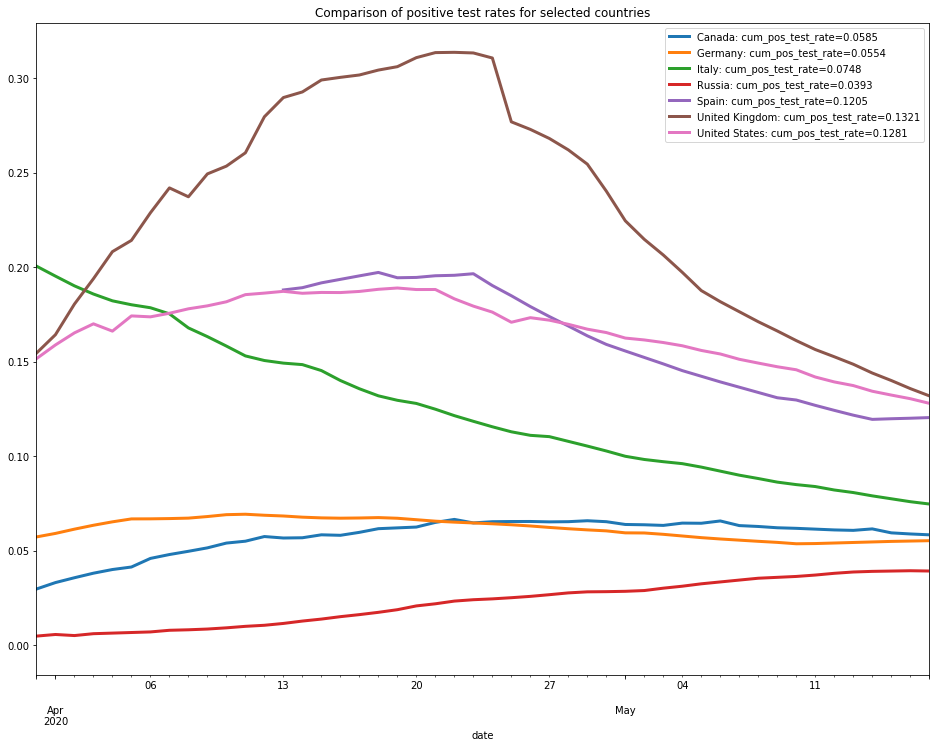

In [15]:

world.plot_var("cum_pos_test_rate", *countries, 
               date_start="2020-03-31",
               date_end="2020-05-17", 
               title="Comparison of positive test rates for selected countries")

savefile = f"2020-05-17_SelectCountries_PosTestRate.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),format="png")


plt.show()

In [16]:
world.get_location('China')[['total_tests', 'tests_units', 'total_tests_per_thousand']]

,total_tests,tests_units,total_tests_per_thousand
3368,NaN,NaN,NaN
3369,NaN,NaN,NaN
3370,NaN,NaN,NaN
3371,NaN,NaN,NaN
3372,NaN,NaN,NaN
...,...,...,...
3509,NaN,NaN,NaN
3510,NaN,NaN,NaN
3511,NaN,NaN,NaN
3512,NaN,NaN,NaN


In [17]:
world.df.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k'],
      dtype='object')

In [18]:
fig = plt.figure(figsize=(16,12))

fig.add_axes()
fig.get_axes()

#ax1 = world.plot_var("total_cases_growth", 'Canada')
#ax2 = world.plot_var("total_cases", 'Canada')

[]

<Figure size 1152x864 with 0 Axes>